In [1]:
import osmnx
import os
import pickle
import scipy.spatial
import numpy as np
import networkx
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
def load_map(fp: str, lat_lon: tuple[float, float], **kwargs):
    if os.path.exists(fp):
        with open(fp, 'rb') as f:
            return pickle.load(f)
    else:
        loaded = osmnx.graph_from_point(lat_lon, **kwargs)
        with open(fp, 'wb') as f:
            return pickle.dump(loaded, f)
        return loaded

In [3]:
test_map = load_map("maps/rice-campus.pickle", (29.717997,-95.400547), dist=1500)

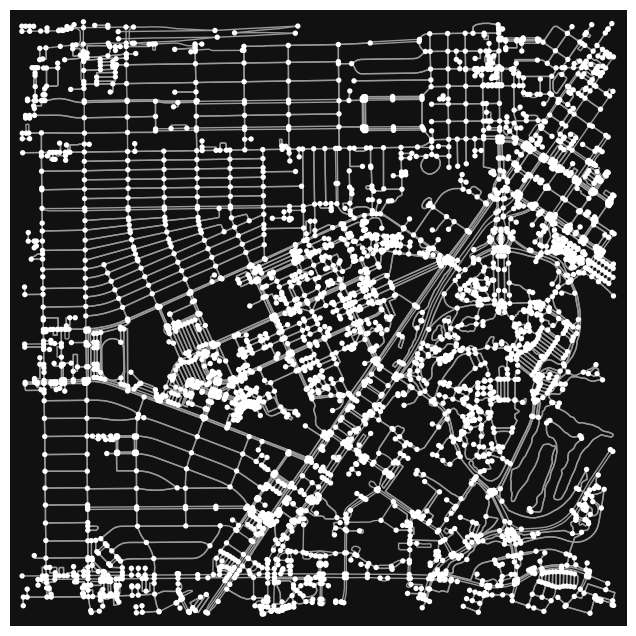

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
osmnx.plot_graph(test_map)

In [5]:
def convexhull(G, key_nodes: list[int], leeway: float = 0.005):
    nodes_df, edges_df = osmnx.convert.graph_to_gdfs(G)
    key_points_xy = nodes_df.loc[key_nodes][['x', 'y']].to_numpy()
    ch = scipy.spatial.ConvexHull(key_points_xy)
    all_points_xy = nodes_df[['x', 'y']].to_numpy()
    print(ch.equations.shape)
    print(all_points_xy.shape)
    is_inside = np.all(np.sum(ch.equations[np.newaxis, :, :2] * all_points_xy[:, np.newaxis, :], axis=2) < -ch.equations[np.newaxis, :, 2] + leeway, axis=1)
    selected_nodes_id = list(nodes_df[is_inside].index)
    sg = osmnx.convert.to_undirected(G)
    sg = networkx.induced_subgraph(sg, selected_nodes_id)
    return sg.copy()
    # return networkx.induced_subgraph(G, selected_nodes_id)

In [6]:
INNER_LOOP_NODES = [7459593424, 7459595014, 2611472516, 151674436, 11529033887, 151764718, 2584454341, 151786655, 1019275181, 8406688429, 2611731387, 583250666, 5265110642, 569257577, 151421265, 11576321623, 151786632, 151378395, 2611731328, 1016949780, 2611731326, 151378198, 151786621, 569254436, 5255143591, 2584454318, 5255143589, 1018674570, 5255134086, 1018674551, 5255134079, 5255134076, 5572595732, 11529033886, 5572595105, 5255134077, 8627037753, 10772010783, 4706040461, 6906798197, 6906798195, 7459593472, 10772010792, 7459593473, 7459593483, 7459593424]
MAIN_STREET_NODES = [1229920388, 151378245, 2161483950, 10772010844, 2161483947, 2611731375, 2161483953]
NODES_OF_INTEREST = INNER_LOOP_NODES + MAIN_STREET_NODES

(17, 3)
(3894, 2)


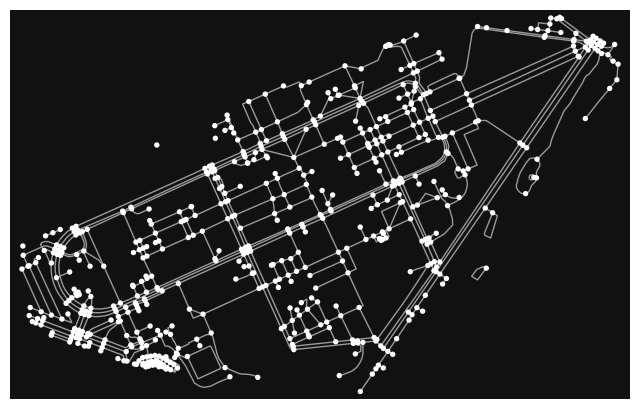

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
reduced_map = convexhull(
    test_map,
    NODES_OF_INTEREST,
    leeway=0.001
)
osmnx.plot.plot_graph(reduced_map)

In [8]:
def shuffled(arr):
    shuffle(arr)
    return arr

In [9]:
def make_path_map(G, points):
    n = len(points)
    return {
        (source, dest): (
            path,
            sum([G.get_edge_data(sn, dn, key=0)['length'] for sn, dn in zip(path[:-1], path[1:])])
        )
        for source, dest, path in zip(np.repeat(points, n), np.tile(points, n), osmnx.routing.shortest_path(G, np.repeat(points, n), np.tile(points, n), cpus=4))
    }

In [145]:
INNER_LOOP_NODES[0]

7459593424

In [132]:
reduced_map.get_edge_data(INNER_LOOP_NODES[0], INNER_LOOP_NODES[1], key=0)

{'osmid': 1152311026,
 'name': 'Loop Road',
 'highway': 'service',
 'oneway': False,
 'reversed': True,
 'length': 37.528,
 'geometry': <LINESTRING (-95.406 29.715, -95.406 29.715, -95.406 29.715, -95.406 29.715)>,
 'from': 7459595014,
 'to': 7459593424}

In [263]:
sorted((3, 2))

[2, 3]

In [359]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def solve_vrp_correct(G, edges, drone_depots, drone_capacity=1e6, scale_factor=1000):
    # distinfo_dict = build_distinfo(G, points)
    forward_edges = [(fro, to) for (fro, to, bidi) in edges]
    backward_edges = [(to, fro) for (fro, to, bidi) in edges if bidi]
    
    forward_backward_indices = [i for i,(fro, to, bidi) in enumerate(edges) if bidi]
    
    all_edges = forward_edges + backward_edges
    n_all_edges = len(all_edges)
    depot_nodes = sorted(list(set(drone_depots)))
    n_all = n_all_edges + len(depot_nodes)
    AVOID_DEPOT_NODES = 10
    points = drone_depots + [p for (u, v, bidi) in edges for p in (u, v)]
    points = list(set(points))
    print("making distance map...")
    path_map = make_path_map(G, points)
    print("made distance map")
    def distance_between(idx1, idx2):
        if idx1 == idx2: return 0.0
        d = 0.0
        if (idx1 < n_all_edges):
            d += G.get_edge_data(*all_edges[idx1], key=0)["length"] / 2
            n1 = all_edges[idx1][1]
        else:
            n1 = depot_nodes[idx1 - n_all_edges]
            d += AVOID_DEPOT_NODES
        if (idx2 < n_all_edges):
            d += G.get_edge_data(*all_edges[idx2], key=0)["length"] / 2
            n2 = all_edges[idx2][0]
        else:
            n2 = depot_nodes[idx2 - n_all_edges]
            d += AVOID_DEPOT_NODES
        _, pl = path_map[(n1, n2)]
        return d + pl
    num_nodes = len(all_edges) + len(depot_nodes)
    num_drones = len(drone_depots)
    depot_idxs = [n_all_edges + depot_nodes.index(depot) for depot in drone_depots]

    manager = pywrapcp.RoutingIndexManager(
        num_nodes, num_drones, depot_idxs, depot_idxs
    )
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        dist = int(distance_between(from_node, to_node) * scale_factor)
        return dist

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    routing.AddDimensionWithVehicleCapacity(
        transit_callback_index,
        0,  # null capacity slack
        [int(drone_capacity * scale_factor)] * num_drones,  # vehicle maximum capacities
        True,  # start cumul to zero
        "Distance",
    )
    
    distance_dimension = routing.GetDimensionOrDie("Distance")
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    for b_index, f_index in enumerate(forward_backward_indices):
        routing.AddDisjunction([f_index, b_index + len(forward_edges)], -1, 1)
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        #routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
    )
    search_parameters.local_search_metaheuristic = (
        #routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
        routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC
    )
    search_parameters.time_limit.FromSeconds(10)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    if not solution:
        print(routing.status())
        raise ValueError("no solution found")

    # extract routes from solution
    unfilled_routes = []
    for drone_id in range(num_drones):
        route_distance = 0.0
        index = routing.Start(drone_id)
        start_ni = manager.IndexToNode(index)
        assert start_ni >= n_all_edges
        this_route = [(None, depot_nodes[start_ni - n_all_edges])]
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            ni = manager.IndexToNode(index)
            if ni >= n_all_edges:
                assert routing.IsEnd(index)
                assert ni == start_ni
                break
            # assert ni < n_all_edges
            this_route.append(all_edges[ni])
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, drone_id
            )
        this_route.append((depot_nodes[start_ni - n_all_edges], None))
        unfilled_routes.append(this_route)
    visited_edges = set([tuple(sorted(e)) for u in unfilled_routes for e in u[1:-1]])
    wanted_edges = set([tuple(sorted([u, v])) for (u, v, bidi) in edges])
    print((len(wanted_edges), len(wanted_edges - visited_edges)))
    print(wanted_edges - visited_edges)
    filled_routes = []
    total_length = 0.0
    for i, route in enumerate(unfilled_routes, 1):
        this_route = []
        drone_length = 0.0
        for (u, v) in route[1:-1]:
            segment, l = path_map[(u, v)]
            drone_length += l
        for (_, u), (v, _) in zip(route[:-1], route[1:]):
            segment, l = path_map[(u, v)]
            drone_length += l
            this_route += segment
        print(f"drone {i} flew for distance {drone_length}")
        total_length += drone_length
        filled_routes.append(this_route)
    print(f"combined distance: {total_length}")
    
    return filled_routes, unfilled_routes

In [363]:
solved_routes, solved_routes_uf = solve_vrp_correct(
    reduced_map,
    shuffled(
        [(fr, to, True) for (fr, to) in zip(INNER_LOOP_NODES[:-1], INNER_LOOP_NODES[1:])] +
        [(fr, to, True) for (fr, to) in zip(MAIN_STREET_NODES[:-1], MAIN_STREET_NODES[1:])]
    ),
    [INNER_LOOP_NODES[10], INNER_LOOP_NODES[10], INNER_LOOP_NODES[10]],
    drone_capacity=2500,
    scale_factor=1000
)

making distance map...
made distance map
(51, 0)
set()
drone 1 flew for distance 1549.3090000000004
drone 2 flew for distance 1912.4089999999999
drone 3 flew for distance 1716.884
combined distance: 5178.602000000001


In [364]:
def show_routes(G, routes, colors, upto = None):
    if len(routes) == 1:
        fig, ax = osmnx.plot.plot_graph_route(
            G,
            routes[0][:upto],
            route_color=colors[0],
            figsize=(8,8),
            orig_dest_size=512,
            show=False
        )
    else:
        fig, ax = osmnx.plot.plot_graph_routes(
            G,
            [r[:upto] for r in routes],
            route_colors=colors,
            figsize=(8,8),
            orig_dest_size=512,
            show=False
        )
    for (color, points) in zip(colors, routes):
        gdf_all = osmnx.convert.graph_to_gdfs(G, edges=False, node_geometry=False)[["x", "y"]]
        xy = gdf_all.loc[points[:upto]].to_numpy()
        if len(xy) < 2: continue
        midpoint = (xy[:-1] + xy[1:]) / 2
        distance = np.linalg.norm(xy[:-1] - xy[1:], axis=1)
        filt = distance > np.percentile(distance, 30)
        for i,(x, y) in enumerate(midpoint[filt], 1):
            ax.annotate(f"{i}", (x, y), ha='center', va='center', color='white', size=9)
    return fig

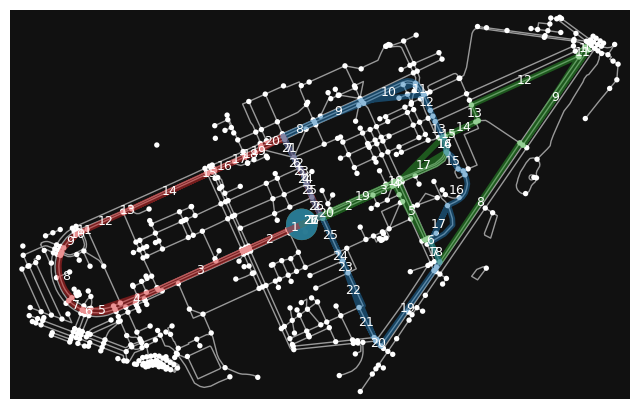

In [365]:
show_routes(reduced_map, solved_routes, ['tab:red', 'tab:green', 'tab:blue'], upto=None)